In [1]:
# @title
# Setup
# https://pyod.readthedocs.io/en/latest/
# pyod for libraries in anomaly detection
#

# === CONFIGURATION ===
# Choose which dataset to use
DATASET_MODE = "marketing"
# options: "RT-IOT2022", "TON-IoT-Fridge", "kddcup99"
# "cic-ids2018-fri02", "cic-ids2018-fri02-sub", "cic-ids2018-fri23",
# "cic-ids2018-thu01", "cic-ids2018-thu15", "cic-ids2018-thu22",
# "cic-ids2018-wed14", "cic-ids2018-wed21", "cic-ids2018-wed28"
DATASET_DIR = "/home/artifact/Documents/network-anomaly-detection/datasets"
RESULTS_DIR = f"/home/artifact/Documents/network-anomaly-detection/results/autoencoder/{DATASET_MODE}"


SAVING = True

# Enable lightweight mode to avoid OOM
# LIGHT_MODE = True          # set False for full data
CHUNK_SIZE = 20000         # adjust for Colab (50k–100k recommended)
SAMPLE_LIMIT = 40000
LIGHT_MODE = False


In [2]:
# Setup
#!pip3 install -U tensorflow
import os
os.makedirs(RESULTS_DIR, exist_ok=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, average_precision_score, precision_recall_curve,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
# from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [3]:

if DATASET_MODE == "RT-IOT2022":
    #!pip3 install -U ucimlrepo
    from ucimlrepo import fetch_ucirepo

    dataset = fetch_ucirepo(id=942)
    X = dataset.data.features
    y = dataset.data.targets
    benign_labels = ['Thing_Speak', 'MQTT_Publish', 'NMAP_XMAS_TREE_SCAN', 'NMAP_TCP_scan',
                 'NMAP_OS_DETECTION', 'NMAP_UDP_SCAN', 'Wipro_bulb', 'NMAP_FIN_SCAN',
                 'DOS_SYN_Hping']
    malicious_column = "Attack_type"
    EXCLUDE_FROM_SCALING = []
    #benign_labels = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb',
    #                 'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    #                 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN']


elif DATASET_MODE.startswith("cic-ids2018-"):
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']
    if DATASET_MODE == "cic-ids2018-fri02":
      filename = DATASET_DIR + "/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-fri02-sub":
      filename = DATASET_DIR + "/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.subset.csv"
    elif DATASET_MODE == "cic-ids2018-fri23":
      filename = DATASET_DIR + "/CIC-IDS2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu01":
      filename = DATASET_DIR + "/CIC-IDS2018/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu15":
      filename = DATASET_DIR + "/CIC-IDS2018/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu22":
      filename = DATASET_DIR + "/CIC-IDS2018/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed14":
      filename = DATASET_DIR + "/CIC-IDS2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed21":
      filename = DATASET_DIR + "/CIC-IDS2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed28":
      filename = DATASET_DIR + "/CIC-IDS2018/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv"


    df =  pd.read_csv(filename, low_memory=True)
    # Attempt to parse timestamp automatically
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

    # Extract hour, minute, and second
    df["hour"] = df["Timestamp"].dt.hour.fillna(0)
    df["minute"] = df["Timestamp"].dt.minute.fillna(0)
    df["second"] = df["Timestamp"].dt.second.fillna(0)

    # Compute cyclical time features
    df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
    df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

    # Drop timestamp and raw time components (keep only sin/cos)
    df = df.drop(columns=["Timestamp", "hour", "minute", "second"])

    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]] if malicious_column in df.columns else None
    print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "TON-IoT-Fridge":
  benign_labels = False
  malicious_column = "label"
  EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

  filename = "/content/drive/MyDrive/datasets-anomaly-detection/TON-IoT/Train_Test_IoT_Fridge.csv"
  df = pd.read_csv(filename, low_memory=True)
  df["Timestamp"] = pd.to_datetime(df["time"], errors="coerce")

  # Extract hour, minute, and second
  df["hour"] = df["Timestamp"].dt.hour.fillna(0)
  df["minute"] = df["Timestamp"].dt.minute.fillna(0)
  df["second"] = df["Timestamp"].dt.second.fillna(0)

  # Compute cyclical time features
  df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
  df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

  # Drop timestamp and raw time components (keep only sin/cos)
  df = df.drop(columns=["Timestamp", "hour", "minute", "second", "time", 'date', 'type'])

  df['temp_condition'] = df['temp_condition'].astype(str).str.strip()

  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "kddcup99":
  benign_labels = [b"normal."]
  malicious_column = "labels"
  EXCLUDE_FROM_SCALING = []
  from sklearn.datasets import fetch_kddcup99
  df = fetch_kddcup99(subset="SA", percent10=True, as_frame=True).frame
  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "CelebA":
    # Using CelebA dataset as a placeholder for testing
    benign_labels = ['0']  # Assuming '0' indicates benign in this context
    malicious_column = "class"
    EXCLUDE_FROM_SCALING = []
    filename = DATASET_DIR + "/DevNet/celeba_baldvsnonbald_normalised.csv"
    df = pd.read_csv(filename, low_memory=True)
    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]].astype(str) if malicious_column in df.columns else None
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index] if y is not None else None


elif DATASET_MODE == "bank":
    benign_labels = ['0']
    malicious_column = "class"
    EXCLUDE_FROM_SCALING = []
    filename = DATASET_DIR + "/DevNet/bank-additional-full_normalised.csv"
    df = pd.read_csv(filename, low_memory=True)
    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]].astype(str) if malicious_column in df.columns else None
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index] if y is not None else None

elif DATASET_MODE == "marketing":
    #!pip3 install -U ucimlrepo
    from ucimlrepo import fetch_ucirepo

    dataset = fetch_ucirepo(id=222)
    X = dataset.data.features
    y = dataset.data.targets
    benign_labels = ['no']
    malicious_column = "y"
    EXCLUDE_FROM_SCALING = []
    #benign_labels = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb',
    #                 'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    #                 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN']


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Initial column names: {X.columns.values}")
print(X.head())

X shape: (45211, 16)
y shape: (45211, 1)
Initial column names: ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day_of_week' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome']
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  
0     NaN            5   may       261         1     -1         0      NaN  
1     NaN            5   may       151         1     -1         0      NaN  
2     NaN            5   may        76         1     -1         0      NaN  
3     NaN            5   

In [4]:

# drop NaN or invalid
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]



num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns
# Identify time features to exclude from scaling

# Automatically exclude only those that exist
excluded_features = [col for col in EXCLUDE_FROM_SCALING if col in num_cols]
num_cols_to_scale = [col for col in num_cols if col not in excluded_features]

if len(X) < 5e5:
    log_transformer = FunctionTransformer(lambda arr: np.log1p(np.abs(arr)))
else:
    log_transformer = FunctionTransformer(lambda arr: arr)  # passthrough for big data

numeric_transformer = Pipeline([
    ('log', log_transformer),
    ('scaler', RobustScaler(quantile_range=(5, 95)))
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Define preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols_to_scale),
    ("passthrough", "passthrough", excluded_features),
    ("cat", categorical_transformer, cat_cols)
])

# Fit on a sample to reduce memory if data huge
sample_rows = min(SAMPLE_LIMIT, len(X))
preprocessor.fit(X.sample(sample_rows, random_state=42))

if LIGHT_MODE:
  # Transform in smaller batches
  def transform_in_chunks(preprocessor, X, chunk_size=CHUNK_SIZE):
      chunks = []
      for i in range(0, len(X), chunk_size):
          X_chunk = X.iloc[i:i+chunk_size]
          X_trans = preprocessor.transform(X_chunk)
          chunks.append(X_trans)
      return np.vstack([c.toarray() if hasattr(c, "toarray") else c for c in chunks])
  print("Transform")
  # Apply transformation safely
  X_scaled = transform_in_chunks(preprocessor, X)
else:
# Apply transformations
  X_scaled = preprocessor.transform(X)

# print(np.min(X_scaled), np.max(X_scaled))
# print(np.mean(X_scaled), np.std(X_scaled))


# Get proper column names
num_features = np.array(num_cols)
cat_features = np.array([])
if len(cat_cols) > 0:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])


# Construct final DataFrame
X = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")
print(f"Final feature count: {X.shape[1]}")
print(X.head())

print(cat_cols)
print(X.shape)
print(y.shape)



Numeric cols: 7, Categorical cols: 9
Final feature count: 47
            age   balance  day_of_week  duration  campaign     pdays  \
24060 -0.172772  0.041809     0.166331 -0.559415  -0.36907 -0.165714   
24062  0.122952 -0.103668     0.166331  0.346370  -0.36907 -0.104369   
24064 -0.172772  0.197763     0.166331 -0.104623  -0.36907 -0.492985   
24072 -0.066292  0.157117     0.185637 -0.342169  -0.36907 -0.529409   
24077 -0.066292 -0.735274     0.204120 -0.114502  -0.36907 -0.200956   

       previous  job_admin.  job_blue-collar  job_entrepreneur  ...  \
24060  0.178747         1.0              0.0               0.0  ...   
24062 -0.251930         1.0              0.0               0.0  ...   
24064  0.317394         0.0              0.0               0.0  ...   
24072  0.317394         0.0              0.0               0.0  ...   
24077  0.178747         0.0              0.0               0.0  ...   

       month_jul  month_jun  month_mar  month_may  month_nov  month_oct  \
2406

In [5]:
class AnomalyDetector(Model):
  def __init__(self, input_dim, activation):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(48, activation=activation),
      layers.Dense(16, activation=activation),
      layers.Dense(8, activation=activation)])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation=activation),
      layers.Dense(48, activation=activation),
      layers.Dense(input_dim, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = AnomalyDetector(input_dim=X.shape[1], activation="relu")
autoencoder.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


In [6]:
def mad_threshold(loss, k, scaled=True):
    med = np.median(loss)
    mad = np.median(np.abs(loss - med))
    return med + k * mad




--- Fold 1/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.1049
              precision    recall  f1-score   support

      Benign       0.77      0.99      0.87       606
     Anomaly       0.00      0.00      0.00       179

    accuracy                           0.77       785
   macro avg       0.39      0.50      0.43       785
weighted avg       0.60      0.77      0.67       785



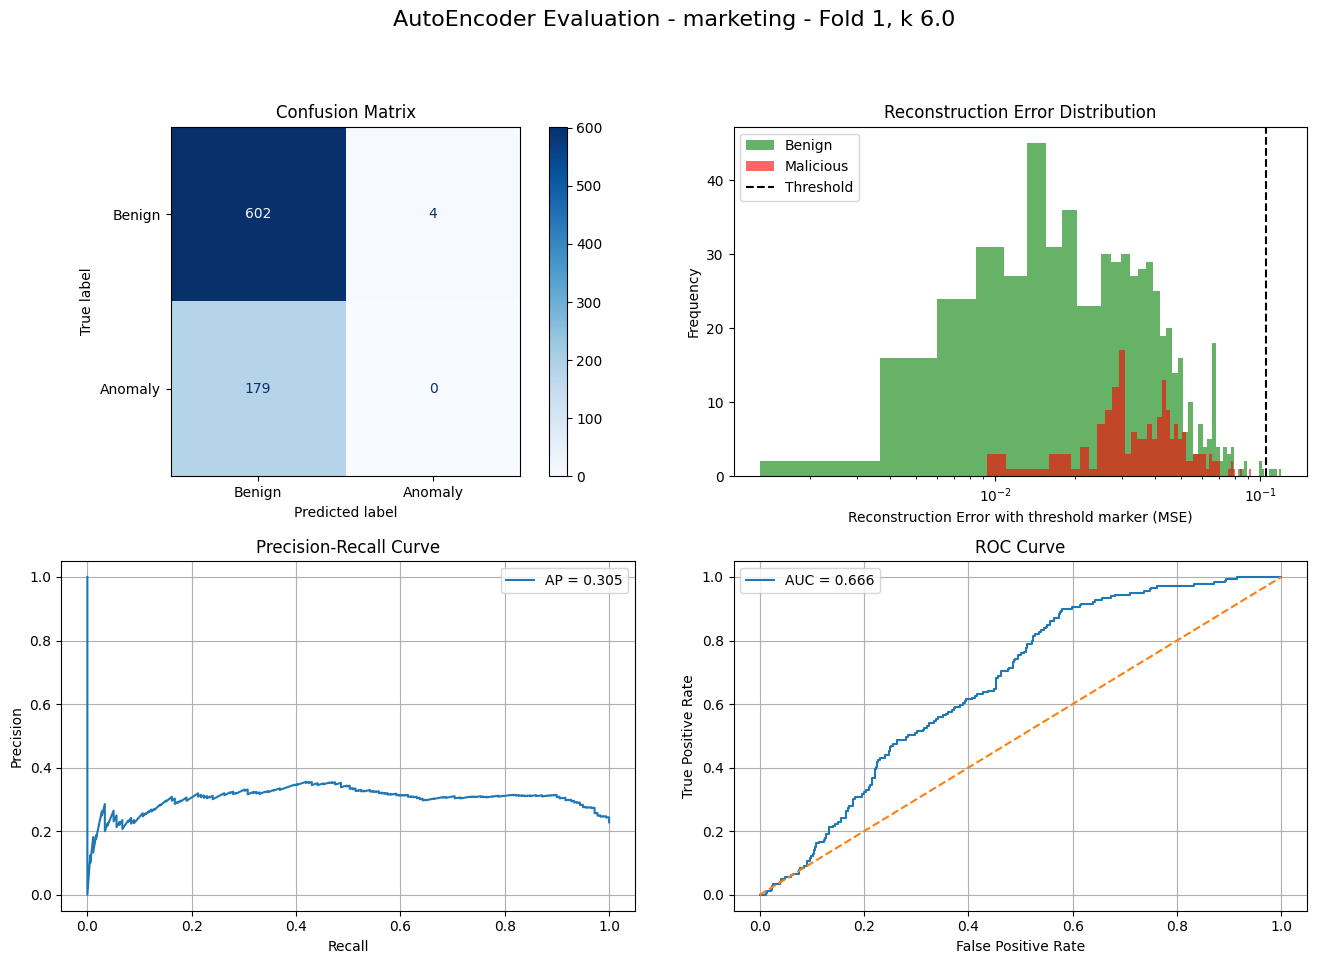

Fold 0 AUROC: 0.6657

--- Fold 2/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.1045
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       606
     Anomaly       0.00      0.00      0.00       179

    accuracy                           0.77       785
   macro avg       0.39      0.50      0.44       785
weighted avg       0.60      0.77      0.67       785



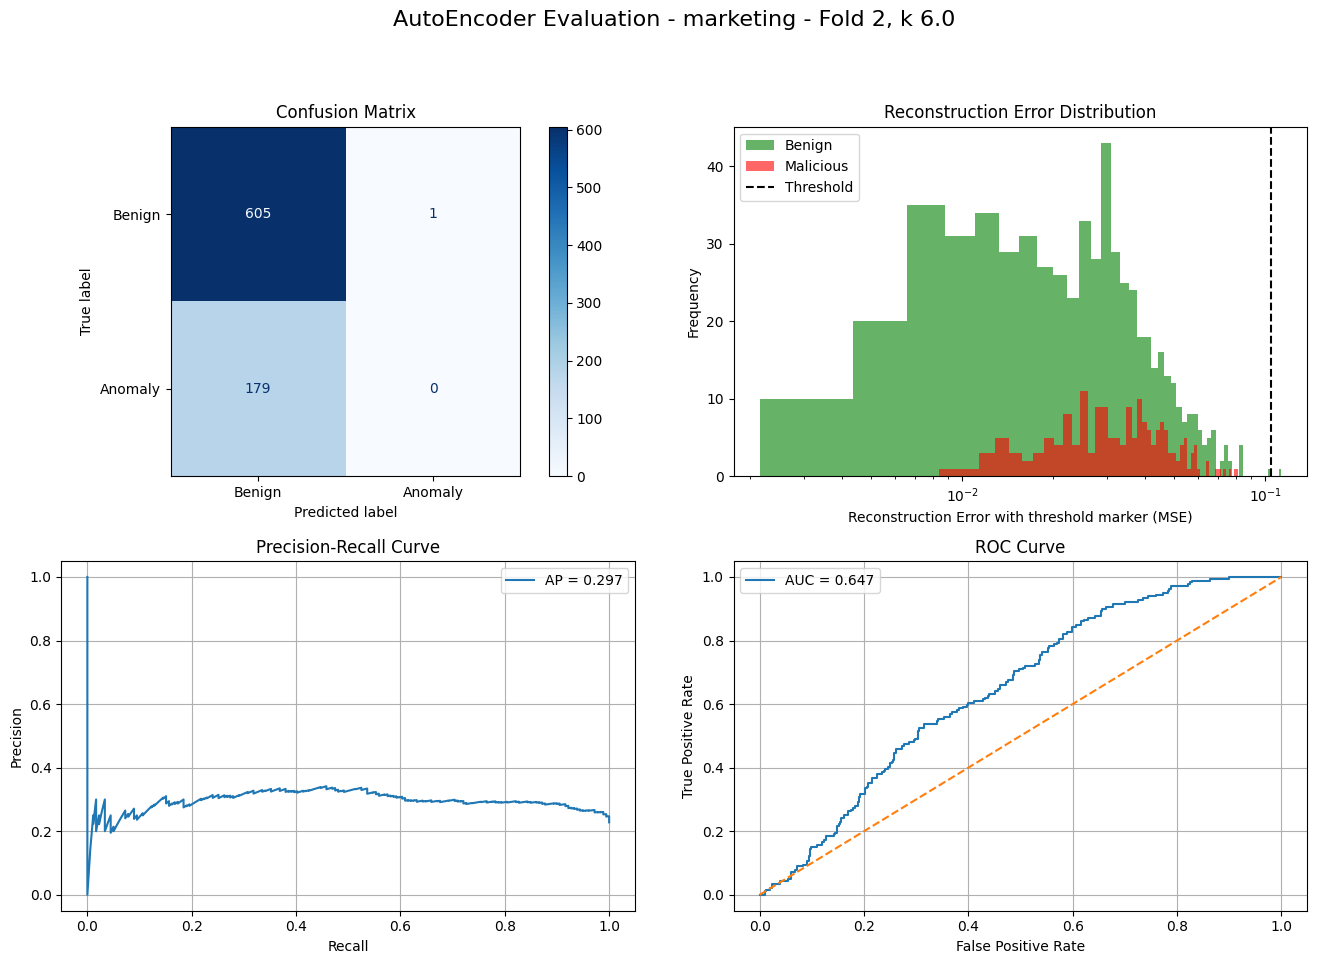

Fold 1 AUROC: 0.6468

--- Fold 3/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Calculated MAD threshold (k=6.0): 0.1040
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       606
     Anomaly       1.00      0.01      0.01       179

    accuracy                           0.77       785
   macro avg       0.89      0.50      0.44       785
weighted avg       0.82      0.77      0.68       785



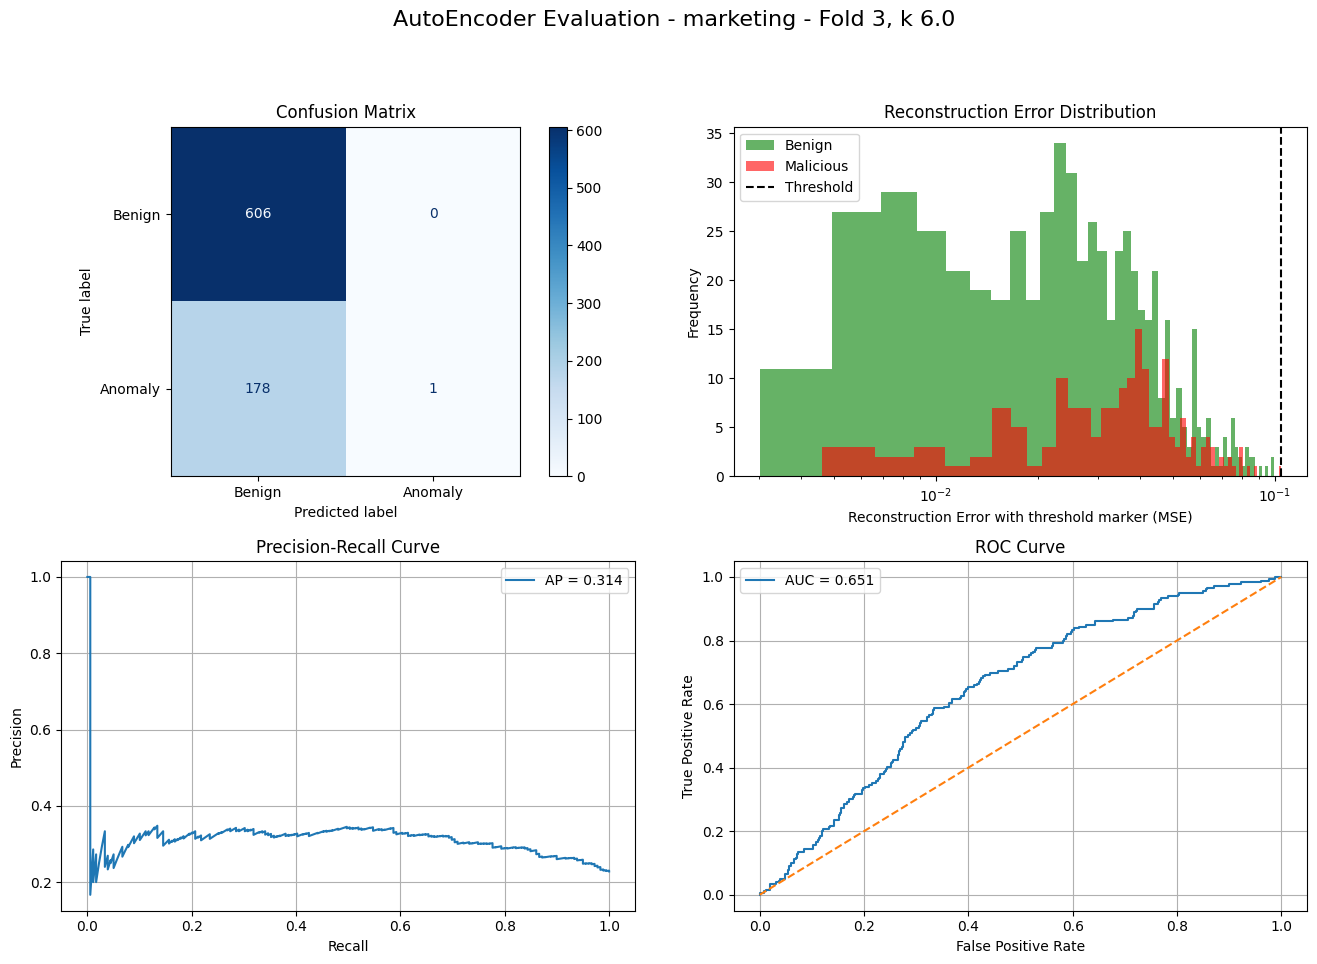

Fold 2 AUROC: 0.6506

--- Fold 4/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.1017
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       606
     Anomaly       0.00      0.00      0.00       179

    accuracy                           0.77       785
   macro avg       0.39      0.50      0.43       785
weighted avg       0.60      0.77      0.67       785



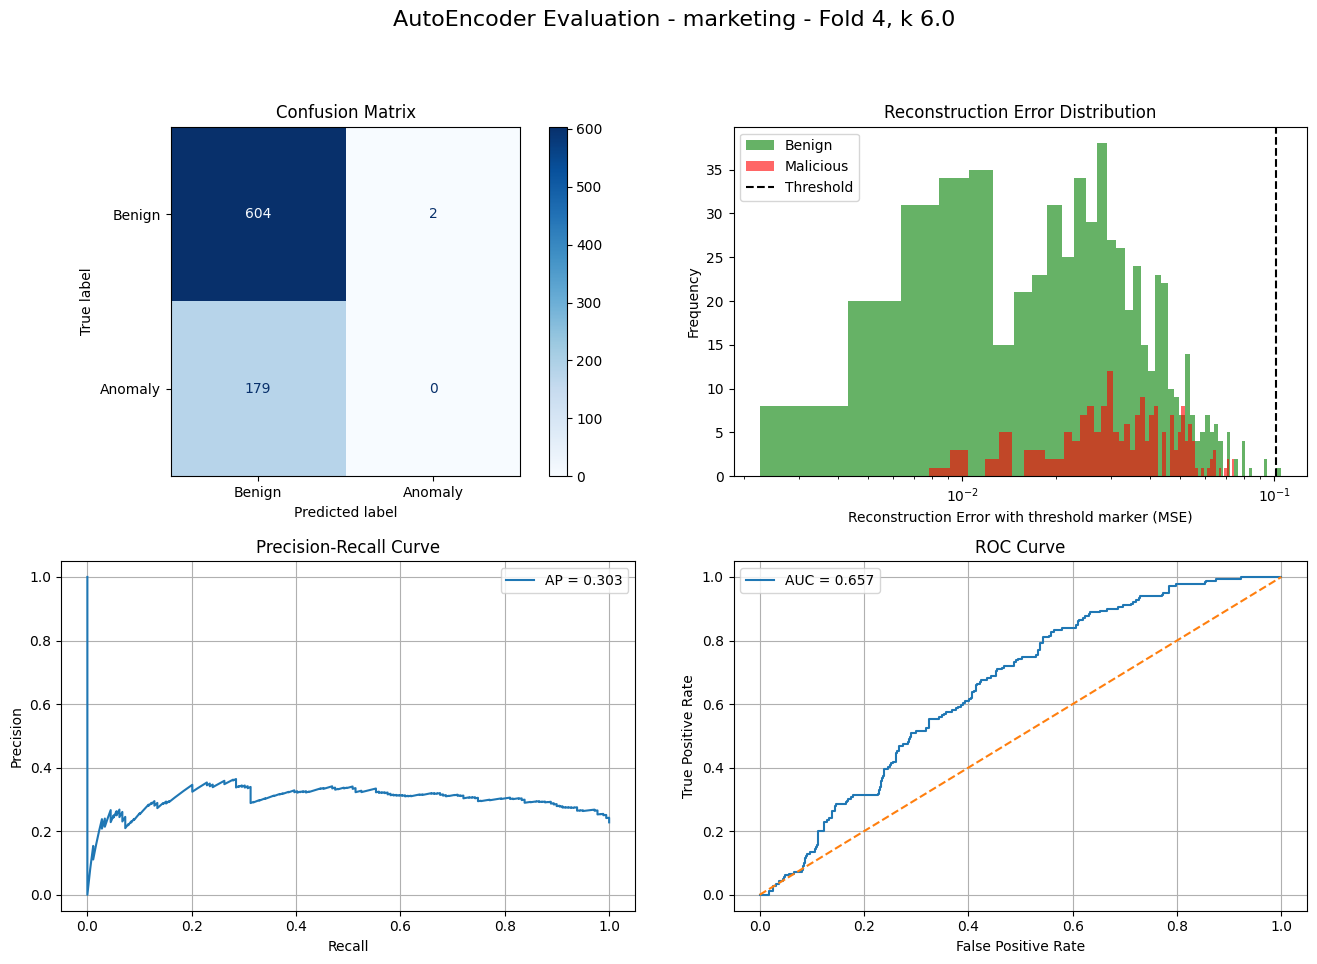

Fold 3 AUROC: 0.6570

--- Fold 5/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Calculated MAD threshold (k=6.0): 0.1088
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       606
     Anomaly       0.00      0.00      0.00       179

    accuracy                           0.77       785
   macro avg       0.39      0.50      0.44       785
weighted avg       0.60      0.77      0.67       785



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


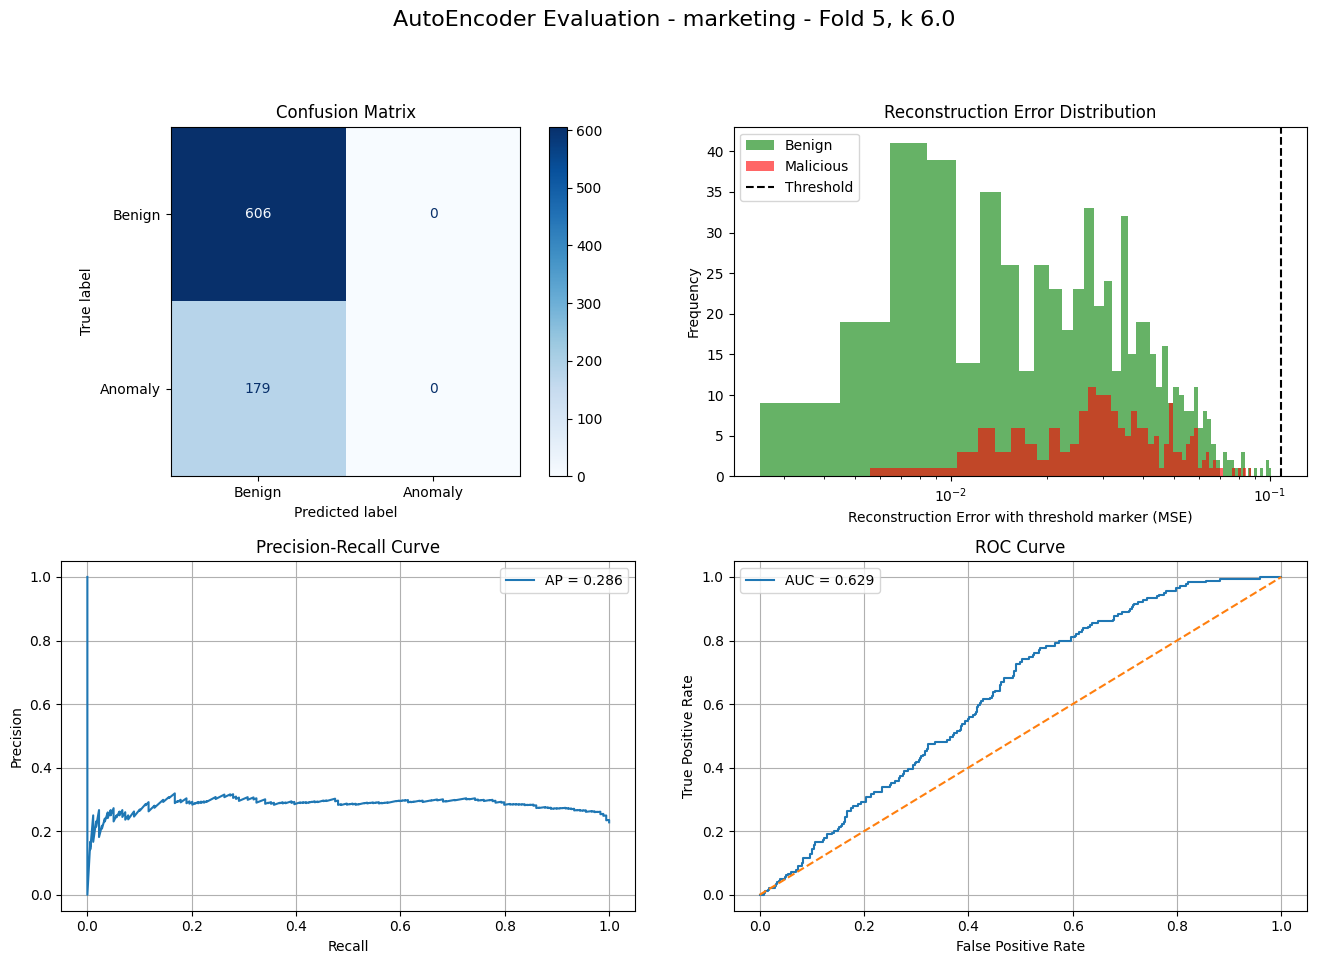

Fold 4 AUROC: 0.6288

--- Fold 6/10 ---
Shape train: (4632, 47), val: (818, 47), test benign: (606, 47), test malicious: (1786, 47)
Test fold shape: (785, 47), labels shape: (785,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.0984
              precision    recall  f1-score   support

      Benign       0.77      0.99      0.87       606
     Anomaly       0.20      0.01      0.01       179

    accuracy                           0.77       785
   macro avg       0.49      0.50      0.44       785
weighted avg       0.64      0.77      0.67       785



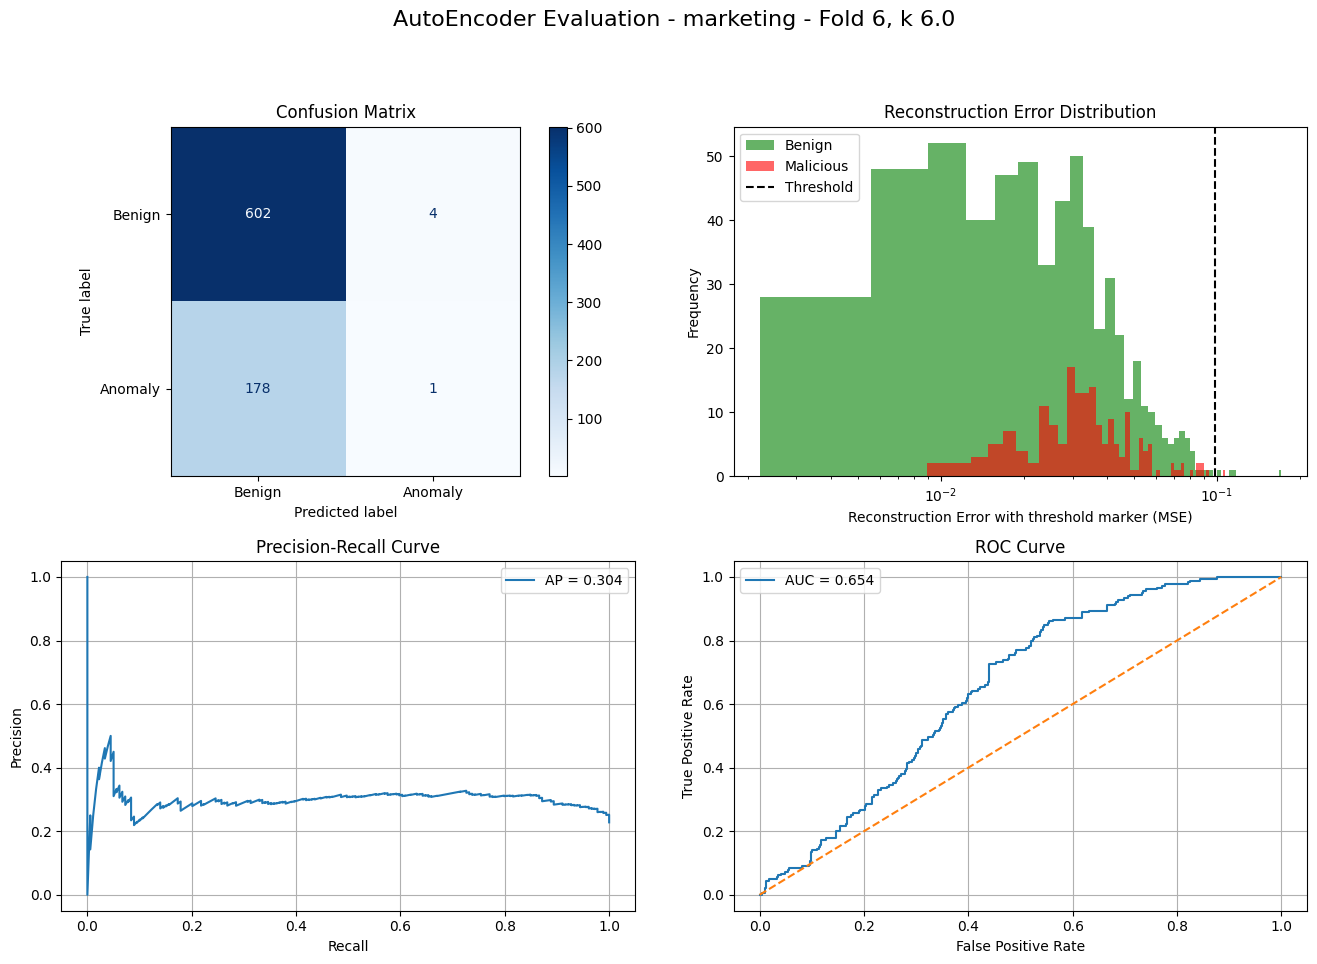

Fold 5 AUROC: 0.6545

--- Fold 7/10 ---
Shape train: (4633, 47), val: (818, 47), test benign: (605, 47), test malicious: (1786, 47)
Test fold shape: (783, 47), labels shape: (783,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.1006
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       605
     Anomaly       0.00      0.00      0.00       178

    accuracy                           0.77       783
   macro avg       0.39      0.50      0.43       783
weighted avg       0.60      0.77      0.67       783



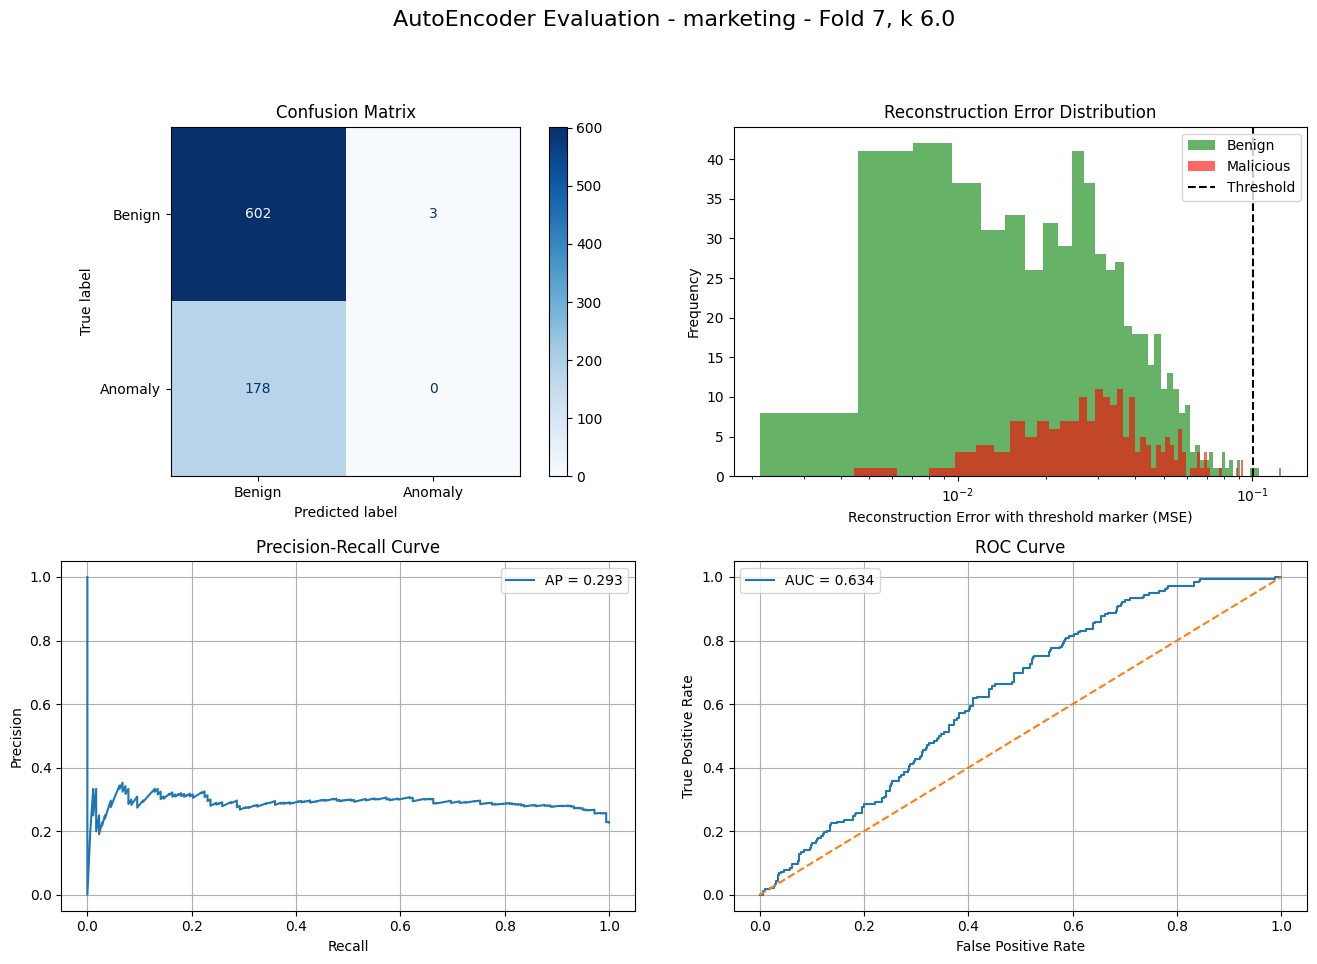

Fold 6 AUROC: 0.6338

--- Fold 8/10 ---
Shape train: (4633, 47), val: (818, 47), test benign: (605, 47), test malicious: (1786, 47)
Test fold shape: (783, 47), labels shape: (783,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.1016
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       605
     Anomaly       1.00      0.01      0.01       178

    accuracy                           0.77       783
   macro avg       0.89      0.50      0.44       783
weighted avg       0.83      0.77      0.68       783



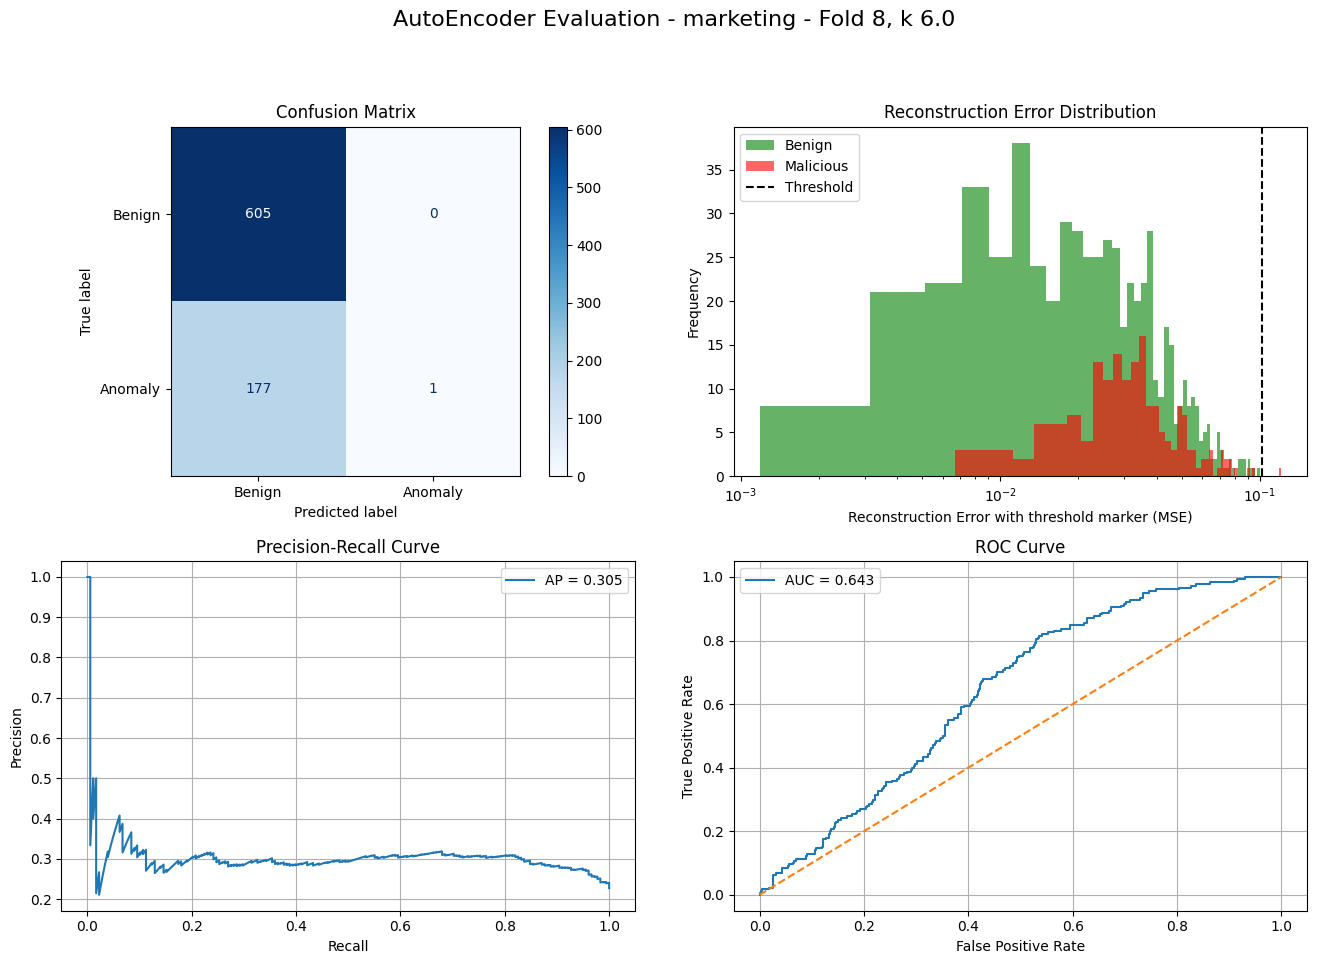

Fold 7 AUROC: 0.6430

--- Fold 9/10 ---
Shape train: (4633, 47), val: (818, 47), test benign: (605, 47), test malicious: (1786, 47)
Test fold shape: (783, 47), labels shape: (783,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.0987
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       605
     Anomaly       0.67      0.01      0.02       178

    accuracy                           0.77       783
   macro avg       0.72      0.50      0.45       783
weighted avg       0.75      0.77      0.68       783



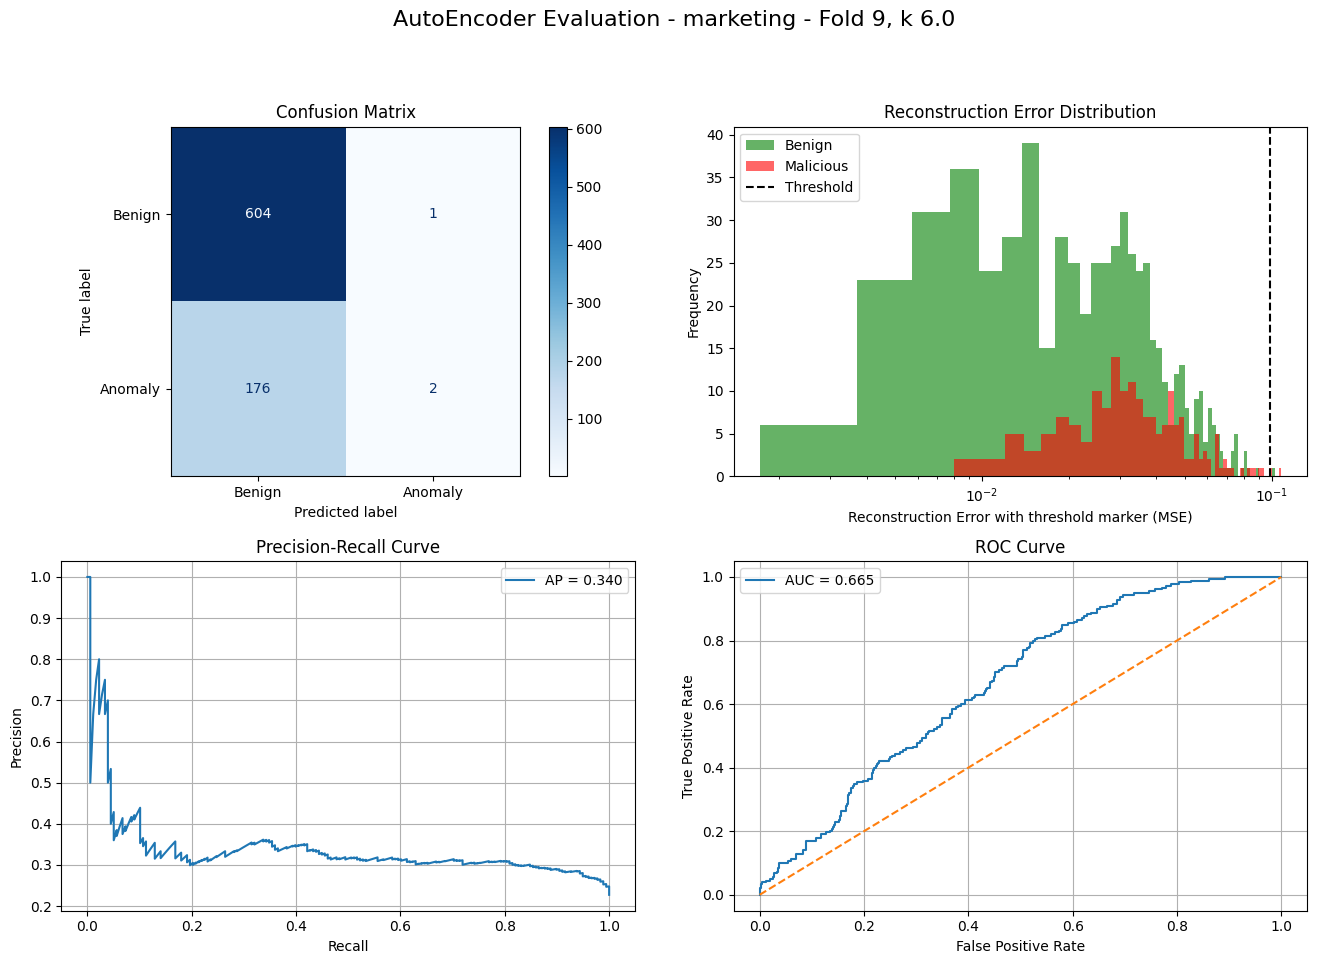

Fold 8 AUROC: 0.6650

--- Fold 10/10 ---
Shape train: (4633, 47), val: (818, 47), test benign: (605, 47), test malicious: (1786, 47)
Test fold shape: (783, 47), labels shape: (783,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Calculated MAD threshold (k=6.0): 0.0919
              precision    recall  f1-score   support

      Benign       0.77      1.00      0.87       605
     Anomaly       0.40      0.01      0.02       178

    accuracy                           0.77       783
   macro avg       0.59      0.50      0.45       783
weighted avg       0.69      0.77      0.68       783



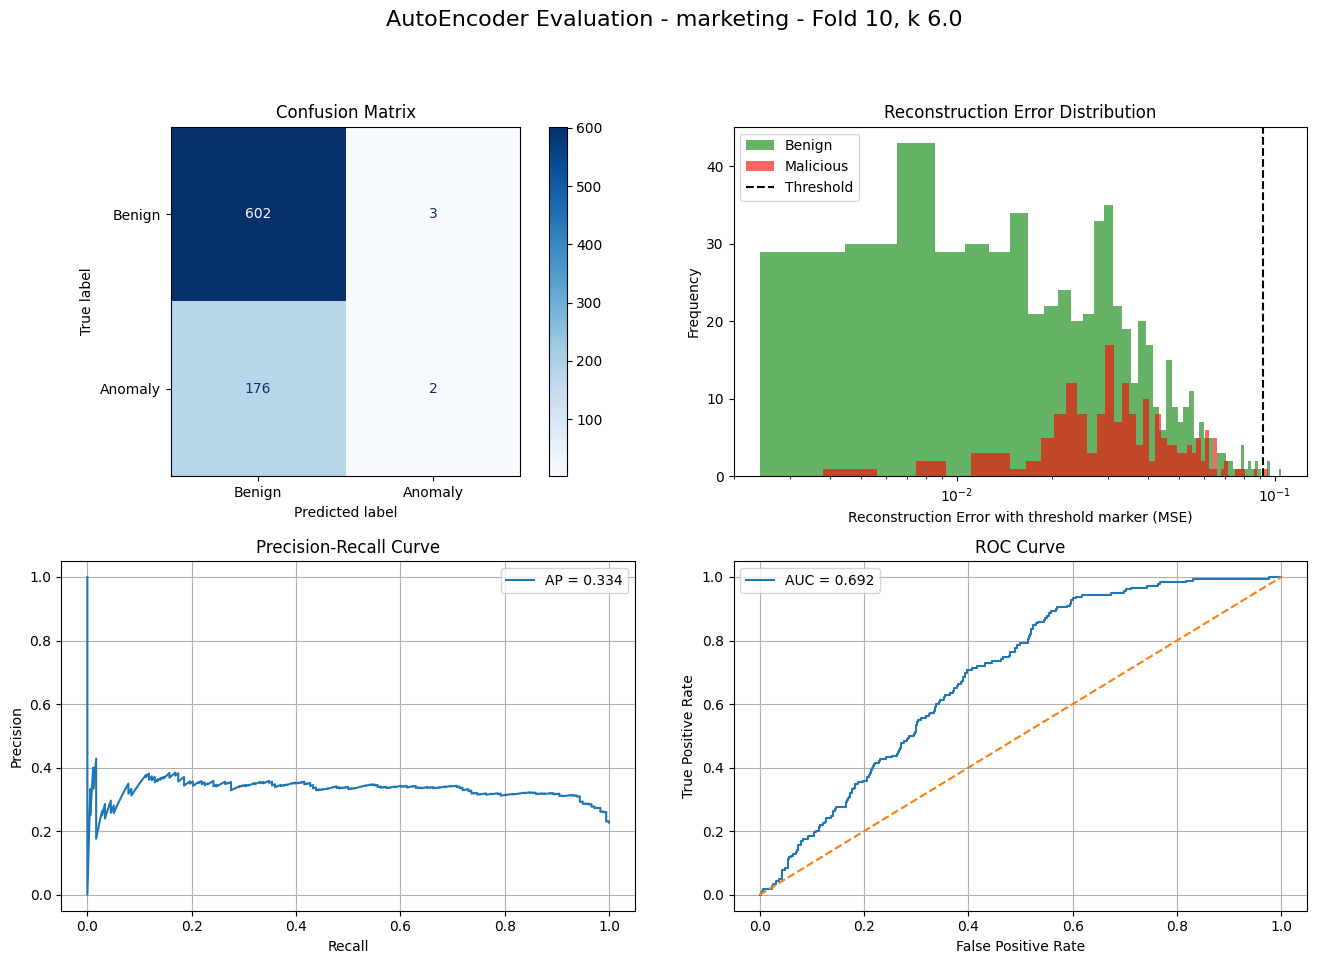

Fold 9 AUROC: 0.6922

Overall AUROC: 0.6537 ± 0.0172
Overall AUPR : 0.3082 ± 0.0162


In [7]:


X_benign = X.loc[y[malicious_column].isin(benign_labels)]
X_malicious = X.loc[~y[malicious_column].isin(benign_labels)]
y_benign = y.loc[y[malicious_column].isin(benign_labels)]
y_malicious = y.loc[~y[malicious_column].isin(benign_labels)]

n_splits = 10
benign_folds = list(KFold(n_splits=10, shuffle=True, random_state=4).split(X_benign))
malicious_folds = list(KFold(n_splits=10, shuffle=True, random_state=4).split(X_malicious))

# Performance for anomaly detection on k-fold
# f1, auc, ap, negative recall (tnr), false omission rate, confusion matrix,
performance_metrics = {
    "model": [],
    "dataset": [],
    "kFold": [],
    "kVal": [],
    "f1_score": [],
    "auc": [],
    "ap": [],
    "tp": [],
    "fp": [],
    "tn": [],
    "fn": [],
    "tnr": [],
    "for": [],
    "cm": []
}

for fold, ((train_idx, test_idx), (mal_train_idx, mal_test_idx)) in enumerate(zip(benign_folds, malicious_folds)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    train_idx, test_idx = benign_folds[fold]
    mal_train_idx, mal_test_idx = malicious_folds[fold]

    X_train_fold = X_benign.iloc[train_idx]
    X_test_benign = X_benign.iloc[test_idx]
    X_test_malicious = X_malicious.iloc[mal_test_idx]

    # Create small validation split from training normals
    X_train_fold, X_val_fold = train_test_split(
        X_train_fold, test_size=0.15, random_state=4
    )
    y_val_fold = np.zeros(len(X_val_fold))
    print(f"Shape train: {X_train_fold.shape}, val: {X_val_fold.shape}, test benign: {X_test_benign.shape}, test malicious: {X_malicious.shape}")
    history = autoencoder.fit(
        X_train_fold, X_train_fold,
        epochs=500,
        batch_size=512,
        validation_data=(X_val_fold, X_val_fold),
        shuffle=True,
        verbose=0,
        callbacks=[es]
    )

    # Test set = benign from fold + all malicious
    X_test_fold = pd.concat([X_test_benign, X_test_malicious])
    y_test_fold = np.concatenate([
        np.zeros(len(X_test_benign)),
        np.ones(len(X_test_malicious))
    ])
    print(f"Test fold shape: {X_test_fold.shape}, labels shape: {y_test_fold.shape}")

    # Predict reconstruction loss in MSE
    recon = autoencoder.predict(X_test_fold)
    loss = np.mean((X_test_fold.to_numpy() - recon) ** 2, axis=1)

    # Reconstruction loss on validation set (Malignant) in MSE
    val_recon = autoencoder.predict(X_val_fold)
    val_loss = np.mean((X_val_fold.to_numpy() - val_recon) ** 2, axis=1)
    # Calculate threshold using MAD
    k_val = 6.0
    threshold = mad_threshold(val_loss, k=k_val)
    print(f"Calculated MAD threshold (k={k_val}): {threshold:.4f}")

    y_pred = (loss > threshold).astype(int)

    # Evaluate
    acc  = accuracy_score(y_test_fold, y_pred)
    prec = precision_score(y_test_fold, y_pred, zero_division=0)
    rec  = recall_score(y_test_fold, y_pred)
    f1   = f1_score(y_test_fold, y_pred)
    roc_auc  = roc_auc_score(y_test_fold, loss)
    fpr, tpr, thresholds = roc_curve(y_test_fold, loss)

    print(classification_report(y_test_fold, y_pred, target_names=["Benign", "Anomaly"]))

    cm = confusion_matrix(y_test_fold, y_pred)
    #tp = cm[0,0]
    #fn = cm[0,1]
    #fp = cm[1,0]
    #tn = cm[1,1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0 # True Negative Rate (Specificity) Negative Recall NOTE: we want it high
    for_rate = fn / (fn + tn) if (fn + tn) > 0 else 0.0 # False Omission Rate NOTE: we want it low
    ap = average_precision_score(y_test_fold, loss)
    precision, recall, _ = precision_recall_curve(y_test_fold, loss)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"AutoEncoder Evaluation - {DATASET_MODE} - Fold {fold+1}, k {k_val}", fontsize=16)
    fig.tight_layout(pad=4.0)
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Anomaly"])
    disp.plot(ax=axes[0, 0], cmap=plt.cm.Blues)
    axes[0, 0].set_title("Confusion Matrix")

    # Reconstruction Error Distribution
    axes[0, 1].hist(loss[y_test_fold == 0], bins=50, alpha=0.6, label='Benign', color="green")
    axes[0, 1].hist(loss[y_test_fold == 1], bins=50, alpha=0.6, label='Malicious', color="red")
    axes[0, 1].axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    axes[0, 1].legend()
    axes[0, 1].set_xlabel("Reconstruction Error with threshold marker (MSE)")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_title("Reconstruction Error Distribution")

    # Precision-Recall Curve
    axes[1, 0].plot(recall, precision, label=f'AP = {ap:.3f}')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # ROC Curve
    axes[1, 1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    axes[1, 1].plot([0, 1], [0, 1], linestyle='--')  # diagonal baseline
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.show()
    if SAVING:
        fig.savefig(f"{RESULTS_DIR}/fold_{fold+1}_evaluation.png")

    print(f"Fold {fold} AUROC: {roc_auc:.4f}")
    performance_metrics["model"].append("AutoEncoder")
    performance_metrics["dataset"].append(DATASET_MODE)
    performance_metrics["kFold"].append(fold)
    performance_metrics["kVal"].append(k_val)
    performance_metrics["f1_score"].append(f1)
    performance_metrics["auc"].append(roc_auc)

    performance_metrics["ap"].append(ap)

    performance_metrics["tp"].append(tp)
    performance_metrics["fp"].append(fp)
    performance_metrics["tn"].append(tn)
    performance_metrics["fn"].append(fn)
    performance_metrics["tnr"].append(tnr)
    performance_metrics["for"].append(for_rate)
    performance_metrics["cm"].append(cm)



# Summarize overall performance
aucs = performance_metrics["auc"]
aps = performance_metrics["ap"]

print(f"\nOverall AUROC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"Overall AUPR : {np.mean(aps):.4f} ± {np.std(aps):.4f}")

# performance metrics -> pandas -> csv file
if SAVING:
    performance_df = pd.DataFrame(performance_metrics)
    performance_df.to_csv(f"{RESULTS_DIR}/performance_results.csv", index=False)